In [1]:
"""

Chicago crimes - crime type classifier.

"""

import findspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import DoubleType
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, IndexToString

import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from sklearn.metrics import confusion_matrix

from pathlib import Path

In [2]:

findspark.init()

spark = SparkSession.builder.appName('ChicagoCrimes').getOrCreate()

In [3]:

files = ['Chicago_Crimes_2005_to_2007.csv', 'Chicago_Crimes_2008_to_2011.csv', 
         'Chicago_Crimes_2012_to_2017.csv']
dfTab = []
csvDir = str(Path.home()) + '/projects/chicago-crimes/'
for f in files:
    df = spark.read.csv(csvDir + f, header=True, inferSchema=True)
    dfTab.append(df)

In [4]:

# crimes = dfTab[2]

crimes = dfTab[0].union(dfTab[1]).union(dfTab[2])

In [5]:
# Drop NA.

crimes2 = crimes.dropna(how='any')

In [6]:
print('Dropped ', crimes.count() - crimes2.count(), ' rows with NA')

Dropped  78195  rows with NA


In [7]:

crimes3 = crimes2.drop("ID", "Case Number")
crimes3.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: double (nullable = true)
 |-- Ward: double (nullable = true)
 |-- Community Area: double (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: double (nullable = true)
 |-- Y Coordinate: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Location: string (nullable = true)



In [8]:
# Convert date to new columns.

crimes3.select("Date").show(3, truncate=False)

tmpdf = crimes3.withColumn('date2', to_timestamp('Date', 'MM/dd/yyyy HH:mm:ss'))
tmpdf.select("date2").show(5)

+----------------------+
|Date                  |
+----------------------+
|04/02/2006 01:00:00 PM|
|02/26/2006 01:40:48 PM|
|01/08/2006 11:16:00 PM|
+----------------------+
only showing top 3 rows

+-------------------+
|              date2|
+-------------------+
|2006-04-02 01:00:00|
|2006-02-26 01:40:48|
|2006-01-08 11:16:00|
|2006-04-05 06:45:00|
|2006-02-17 09:03:14|
+-------------------+
only showing top 5 rows



In [9]:

crimes4 = tmpdf.withColumn('Year', year('date2')).withColumn('Month', month('date2'))\
    .withColumn('Day', dayofmonth('date2')).withColumn('Hour', hour('date2'))\
    .withColumn('Minute', minute('date2'))

crimes4 = crimes4.drop("Date", "date2", "Updated On")
crimes4.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: double (nullable = true)
 |-- Ward: double (nullable = true)
 |-- Community Area: double (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: double (nullable = true)
 |-- Y Coordinate: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Minute: integer (nullable = true)



In [10]:

# Convert categorical attributes to numerical. 
categorical_columns = ['Block', 'IUCR', 'Description', 'Location Description', 
                       'FBI Code']

indexers = [StringIndexer(inputCol=column, outputCol=column+"Index") 
            for column in categorical_columns]

pipeline = Pipeline(stages=indexers)
indexed_df = pipeline.fit(crimes4).transform(crimes4)

In [11]:

for col in categorical_columns:
    indexed_df = indexed_df.drop(col)
crimes5 = indexed_df.drop("Location")
crimes5.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: double (nullable = true)
 |-- Ward: double (nullable = true)
 |-- Community Area: double (nullable = true)
 |-- X Coordinate: double (nullable = true)
 |-- Y Coordinate: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Minute: integer (nullable = true)
 |-- BlockIndex: double (nullable = false)
 |-- IUCRIndex: double (nullable = false)
 |-- DescriptionIndex: double (nullable = false)
 |-- Location DescriptionIndex: double (nullable = false)
 |-- FBI CodeIndex: double (nullable = false)



In [12]:
def plotHistogram(crimes_df, targetCol):
    ptypes = crimes_df.select(targetCol).distinct().rdd.flatMap(lambda x: x).collect()
    bins, counts = crimes_df.select(targetCol).rdd.flatMap(lambda x: x).histogram(sorted(ptypes))
    df = pd.DataFrame(list(zip(bins, counts)), columns=['bin', 'frequency']).set_index('bin')

    ax = df.sort_values(by='frequency', ascending=True).plot(kind='barh', figsize=(20,10), 
                                                      title='Amount of Crimes by Primary Type')

    ax.set_xlabel("Amount of Crimes")
    ax.set_ylabel("Crime Type") 
    return df

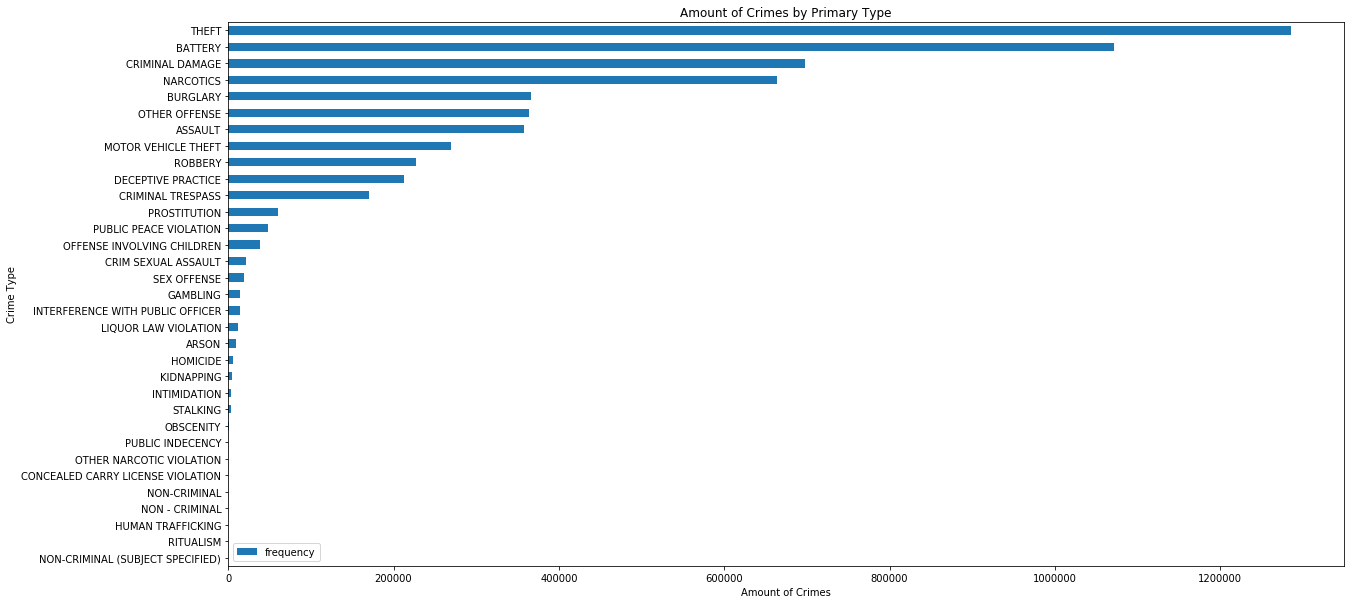

In [13]:
# Show histogram of Primary Type.
df = plotHistogram(crimes5, 'Primary Type')


In [14]:

unwanted_classes = df[df['frequency'] < 20000]

In [15]:

classes_to_exclude = list(unwanted_classes.index)
print(classes_to_exclude)

['ARSON', 'CONCEALED CARRY LICENSE VIOLATION', 'GAMBLING', 'HOMICIDE', 'HUMAN TRAFFICKING', 'INTERFERENCE WITH PUBLIC OFFICER', 'INTIMIDATION', 'KIDNAPPING', 'LIQUOR LAW VIOLATION', 'NON - CRIMINAL', 'NON-CRIMINAL', 'NON-CRIMINAL (SUBJECT SPECIFIED)', 'OBSCENITY', 'OTHER NARCOTIC VIOLATION', 'PUBLIC INDECENCY', 'RITUALISM', 'SEX OFFENSE', 'STALKING']


In [16]:
from pyspark.sql.functions import when, col

tmpdf = crimes5.withColumn('PrimaryType', 
                           when(col('Primary Type').isin(classes_to_exclude), 'OTHER')
                           .otherwise(col('Primary Type')))

# Check    
# tmpdf.select('PrimaryType', 'Primary Type').filter(col('PrimaryType') == 'OTHER').show(5)

crimes6 = tmpdf.drop('Primary Type')

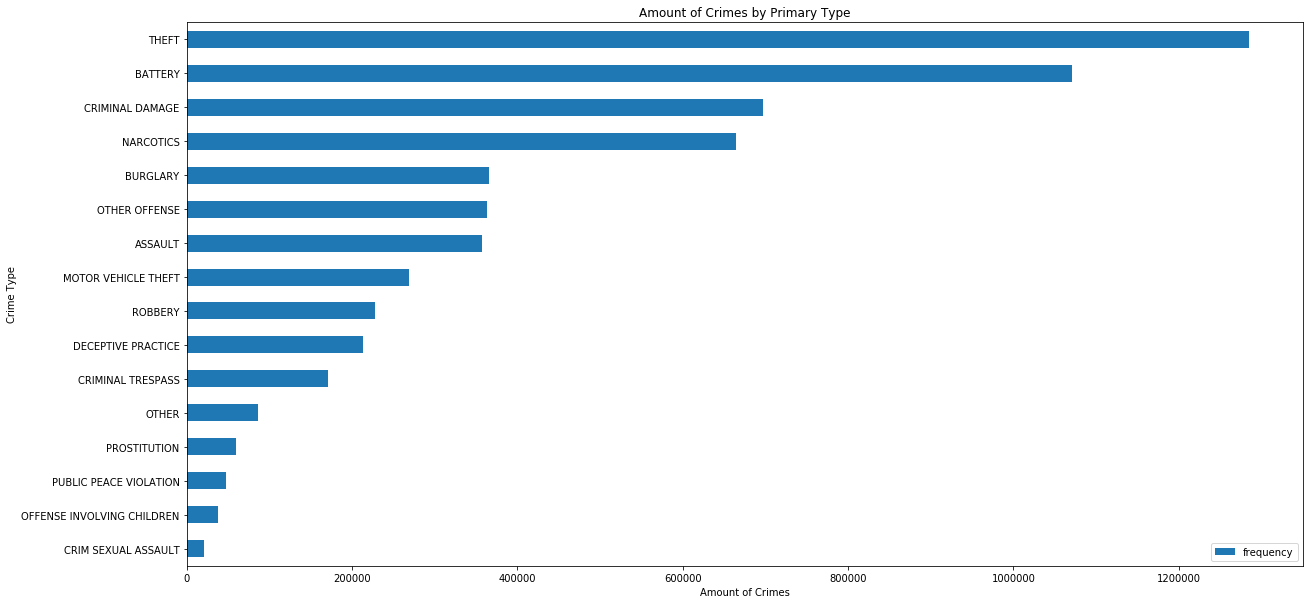

In [17]:
# Show histogram of PrimaryType.

df = plotHistogram(crimes6, 'PrimaryType')


In [18]:

Classes = crimes6.select('PrimaryType').distinct().rdd.flatMap(lambda x: x).collect()
print(Classes)

['OFFENSE INVOLVING CHILDREN', 'PUBLIC PEACE VIOLATION', 'CRIMINAL TRESPASS', 'ASSAULT', 'MOTOR VEHICLE THEFT', 'THEFT', 'BATTERY', 'ROBBERY', 'CRIM SEXUAL ASSAULT', 'OTHER', 'PROSTITUTION', 'DECEPTIVE PRACTICE', 'CRIMINAL DAMAGE', 'NARCOTICS', 'OTHER OFFENSE', 'BURGLARY', 'WEAPONS VIOLATION']


In [19]:
# Convert categorical target to numerical. 

primaryTypeIndexer = StringIndexer(inputCol='PrimaryType', outputCol="PrimaryTypeIndex")
primaryTypeIndexerModel = primaryTypeIndexer.fit(crimes6)
tmpdf = primaryTypeIndexerModel.transform(crimes6)

crimes7 = tmpdf

crimes_for_corr = tmpdf.drop("PrimaryType")

In [20]:
crimes_for_corr.select('PrimaryTypeIndex').show(5)

+----------------+
|PrimaryTypeIndex|
+----------------+
|             5.0|
|             3.0|
|             6.0|
|             1.0|
|             3.0|
+----------------+
only showing top 5 rows



In [21]:
# print(crimes_for_corr.dtypes)
# Convert Longitude to double

tmpdf = crimes_for_corr.withColumn("longitude", crimes_for_corr["Longitude"].cast(DoubleType()))
crimes_for_corr = tmpdf.drop("Longitude")

In [22]:
# Feature selection.


def correlation_matrix(df, corr_columns, method='pearson'):
    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols=corr_columns, outputCol=vector_col)
    df_vector = assembler.setHandleInvalid("skip").transform(df).select(vector_col)
    matrix = Correlation.corr(df_vector, vector_col, method)

    result = matrix.collect()[0]["pearson({})".format(vector_col)].values
    return pd.DataFrame(result.reshape(-1, len(corr_columns)), columns=corr_columns, index=corr_columns)

In [23]:

matrix = correlation_matrix(crimes_for_corr, crimes_for_corr.columns)

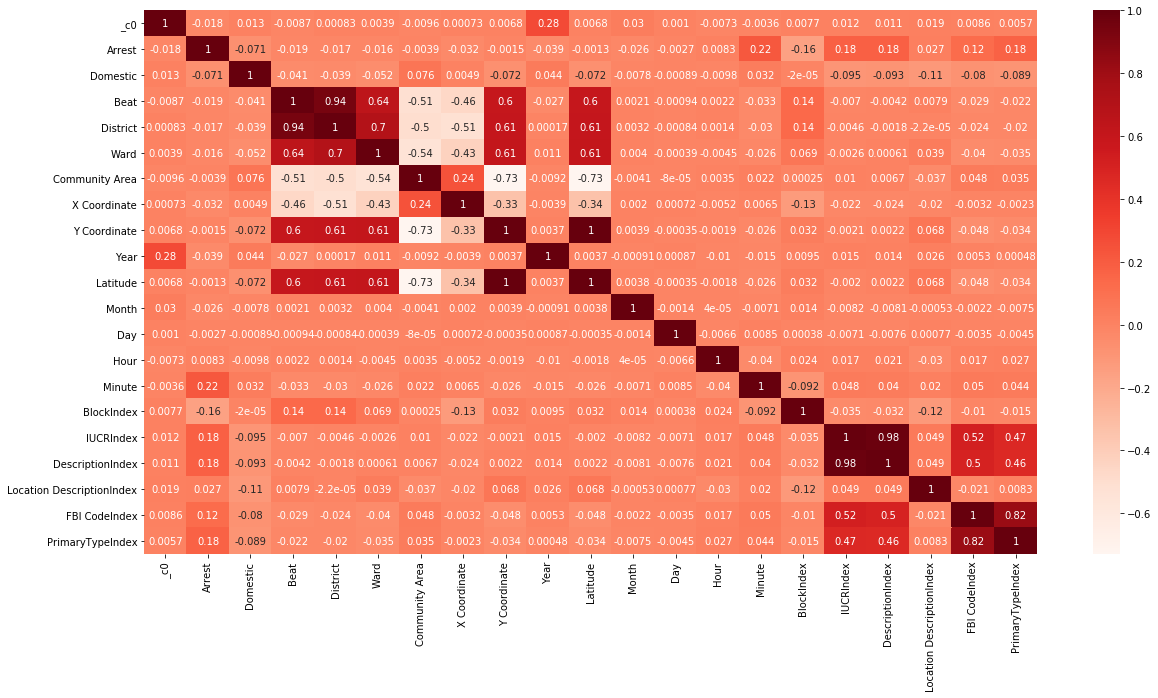

In [24]:

plt.figure(figsize=(20,10))
sns.heatmap(matrix, annot=True, cmap=plt.cm.Reds)
plt.show()

In [25]:

# Correlation with output variable
cor_target = matrix['PrimaryTypeIndex'].abs()
# Selecting highly correlated features
relevant_features = cor_target[cor_target > 0.2]
print(relevant_features)

IUCRIndex           0.473002
DescriptionIndex    0.460587
FBI CodeIndex       0.822046
PrimaryTypeIndex    1.000000
Name: PrimaryTypeIndex, dtype: float64


In [26]:

Features = [ 'IUCRIndex', 'DescriptionIndex', 'FBI CodeIndex']
Target = 'PrimaryTypeIndex'

In [27]:
# Create 'features' column for RandomForest.

assembler = VectorAssembler(inputCols=Features, outputCol="features")
crimes9 = assembler.transform(crimes7)

crimes9.select(Features + ['features']).show(3)

+---------+----------------+-------------+----------------+
|IUCRIndex|DescriptionIndex|FBI CodeIndex|        features|
+---------+----------------+-------------+----------------+
|     16.0|            15.0|          4.0| [16.0,15.0,4.0]|
|     47.0|            45.0|          3.0| [47.0,45.0,3.0]|
|     26.0|            20.0|         11.0|[26.0,20.0,11.0]|
+---------+----------------+-------------+----------------+
only showing top 3 rows



In [28]:
# Split dataset to Training Set & Test Set

test_df, train_df = crimes9.randomSplit([0.2, 0.8], 3)

In [29]:
from pyspark.ml.classification import RandomForestClassifier

In [30]:
# Train a RandomForest model.

rf = RandomForestClassifier(labelCol="PrimaryTypeIndex", featuresCol="features", 
                            numTrees=70, maxBins=400, maxDepth=15, minInstancesPerNode=30)

outputConverter = IndexToString(inputCol="prediction", outputCol="predictedPrimaryType")
outputConverter.setLabels(primaryTypeIndexerModel.labels)

IndexToString_c856ff522efa

In [31]:

pipeline = Pipeline(stages=[rf, outputConverter])
model = pipeline.fit(train_df)

In [32]:

# Make predictions.

predictions = model.transform(test_df)

In [33]:

predictions.select('features', 'PrimaryType', 'predictedPrimaryType').show(5)

+-----------------+-------------------+--------------------+
|         features|        PrimaryType|predictedPrimaryType|
+-----------------+-------------------+--------------------+
|  [16.0,15.0,4.0]|      OTHER OFFENSE|       OTHER OFFENSE|
| [26.0,20.0,11.0]|            ASSAULT|             ASSAULT|
|    [8.0,0.0,6.0]|            ASSAULT|             ASSAULT|
|    [6.0,6.0,3.0]|          NARCOTICS|           NARCOTICS|
|[137.0,131.0,7.0]|MOTOR VEHICLE THEFT| MOTOR VEHICLE THEFT|
+-----------------+-------------------+--------------------+
only showing top 5 rows



In [34]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Select (prediction, true label) and compute test error

evaluator = MulticlassClassificationEvaluator(labelCol="PrimaryTypeIndex", 
                                              predictionCol="prediction", 
                                              metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Model accuracy: ", accuracy)

Model accuracy:  0.9931300170781614


In [35]:

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    """This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`."""
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white"  if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [36]:
    
class_temp = predictions.select("PrimaryType").groupBy("PrimaryType")\
    .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["PrimaryType"].values.tolist()

In [37]:

y_true = predictions.select("PrimaryType")
y_true = y_true.toPandas()
y_pred = predictions.select("predictedPrimaryType")
y_pred = y_pred.toPandas()

In [38]:

cnf_matrix = confusion_matrix(y_true, y_pred, labels=class_temp)
print(cnf_matrix)

[[244478      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0]
 [     0 214843      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0]
 [     0      0 138779      0      0      0      0      0      0      0
       0      0      0      0      0      0      0]
 [     0      0      0 132832    631      0      0      0      0      0
       0      0      0      0      0      0      0]
 [     0      0      0      0  72493      0      0      0      0      0
       0    677      0      0      0      0      0]
 [     0      0      0      0      0  72874      0      0      0      0
       0      0      0      0      0      0      0]
 [     0      0      0      0      0      0  71472      0      0      0
       0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0  53985      0      0
       0      0      0      0      0      0      0]
 [     0

Confusion matrix, without normalization


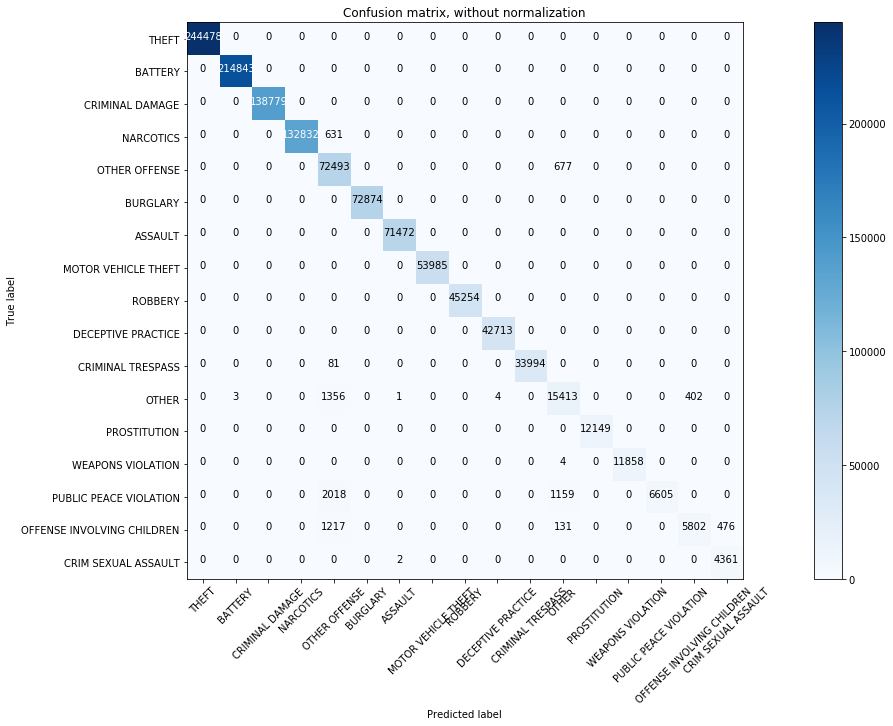

In [39]:
# Plot non-normalized confusion matrix

plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, classes=class_temp, 
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix


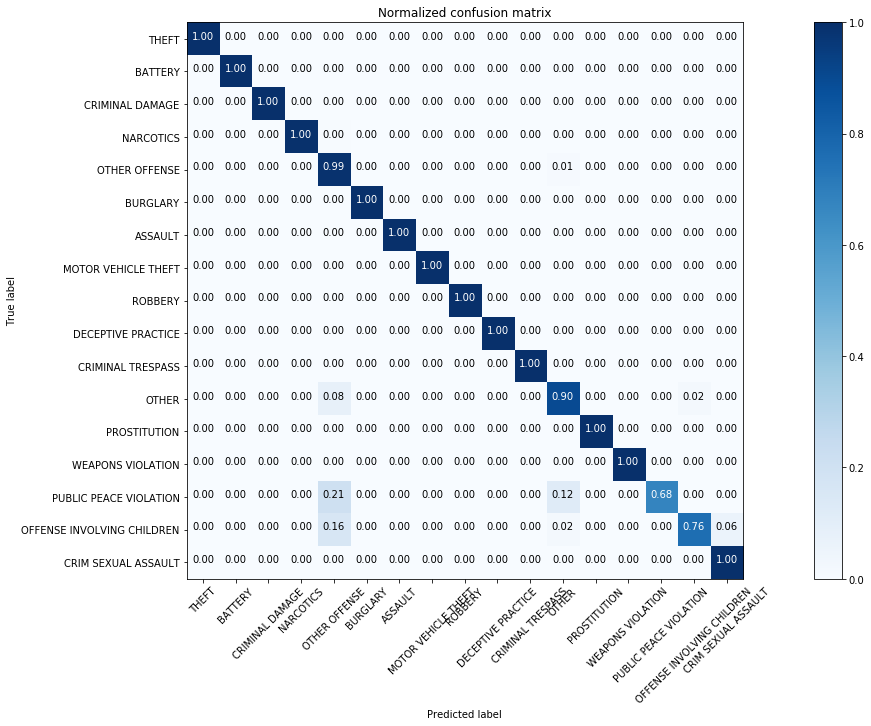

In [40]:
# Plot normalized confusion matrix

plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, classes=class_temp, normalize=True,
                      title='Normalized confusion matrix')
plt.show()